**Ressources**:

- [TF Tutorial](https://www.tensorflow.org/tutorials/images/segmentation)

This tutorial uses the [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/%7Evgg/data/pets/) ([Parkhi et al, 2012](https://www.robots.ox.ac.uk/%7Evgg/publications/2012/parkhi12a/parkhi12a.pdf)). The dataset consists of images of 37 pet breeds, with 200 images per breed (~100 each in the training and test splits). Each image includes the corresponding labels, and pixel-wise masks. The masks are class-labels for each pixel. Each pixel is given one of three categories:

* Class 1: Pixel belonging to the pet.
* Class 2: Pixel bordering the pet.
* Class 3: None of the above/a surrounding pixel.

In [1]:
#!pip install git+https://github.com/tensorflow/examples.git

In [2]:
#!pip install tensorflow_datasets

In [3]:
import tensorflow as tf

import tensorflow_datasets as tfds

In [4]:
from tensorflow_examples.models.pix2pix import pix2pix

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [6]:
#!pip install -U jupyter

In [7]:
#!pip install ipywidgets

In [8]:
#!jupyter nbextension enable --py widgetsnbextension

In [9]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Metal device set to: Apple M1


2022-02-10 14:37:00.834657: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-10 14:37:00.834781: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [106]:
dataset['train']

<PrefetchDataset shapes: {file_name: (), image: (None, None, 3), label: (), segmentation_mask: (None, None, 1), species: ()}, types: {file_name: tf.string, image: tf.uint8, label: tf.int64, segmentation_mask: tf.uint8, species: tf.int64}>

In [90]:
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_path='/Users/fabioteichmann/tensorflow_datasets/oxford_iiit_pet/3.2.0',
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
 

In [100]:
info.splits['train']

[FileInstruction(filename='oxford_iiit_pet-train.tfrecord-00000-of-00004', skip=0, take=-1, num_examples=920),
 FileInstruction(filename='oxford_iiit_pet-train.tfrecord-00001-of-00004', skip=0, take=-1, num_examples=920),
 FileInstruction(filename='oxford_iiit_pet-train.tfrecord-00002-of-00004', skip=0, take=-1, num_examples=920),
 FileInstruction(filename='oxford_iiit_pet-train.tfrecord-00003-of-00004', skip=0, take=-1, num_examples=920)]

In [10]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

In [11]:
def load_image(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [12]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [13]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [107]:
train_images

<ParallelMapDataset shapes: ((128, 128, 3), (128, 128, 1)), types: (tf.float32, tf.float32)>

In [89]:
for i in train_images.as_numpy_iterator():
    print(i[0].shape)
    print(i[1].shape)
    break

(128, 128, 3)
(128, 128, 1)


In [60]:
class Augment(tf.keras.layers.Layer):
    def __init__(self, seed=42):
        super().__init__()
        # both use the same seed, so they'll make the same random changes.
        self.seed = seed
        # self.augment_inputs = tf.image.random_flip_left_right(seed=seed)
        # self.augment_labels = tf.image.random_flip_left_right(seed=seed)

    def call(self, inputs, labels):
        inputs = tf.image.random_flip_left_right(inputs, seed=self.seed)
        labels = tf.image.random_flip_left_right(labels, seed=self.seed)
        return inputs, labels

In [61]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

In [62]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis('off')
        plt.show()

In [63]:
#images, masks = train_batches.take(-1)

In [64]:
a = train_batches.take(2)

In [ ]:
list(a.as_numpy_iterator())

In [ ]:
!pip freeze

(128, 128, 1)


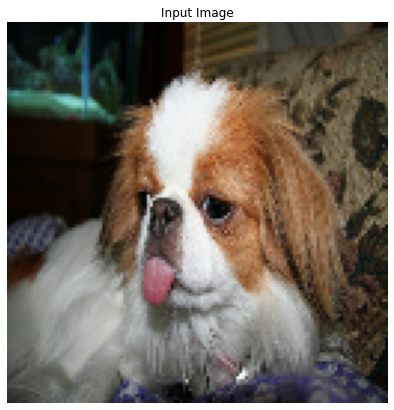

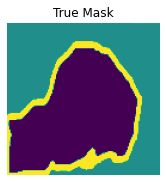

(128, 128, 1)


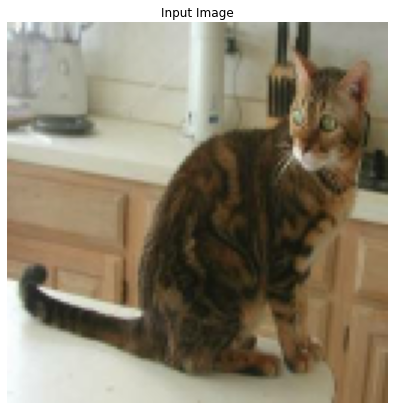

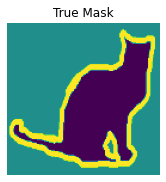

In [80]:
tf.keras.backend.clear_session()

for images, masks in train_batches.take(2).as_numpy_iterator():
    sample_image, sample_mask = images[0], masks[0]
    print(sample_mask.shape)
    display([sample_image, sample_mask])

---

### Build a Model

Using a pretrained `MobileNetV2`

The model being used here is a modified U-Net. A U-Net consists of an encoder (downsampler) and decoder (upsampler). In-order to learn robust features and reduce the number of trainable parameters, you will use a pretrained model - [`MobileNetV2`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/mobilenet_v2/MobileNetV2) - as the encoder. For the decoder, you will use the upsample block, which is already implemented in the pix2pix example in the TensorFlow Examples repo. (Check out the [pix2pix: Image-to-image translation with a conditional GAN](https://www.tensorflow.org/tutorials/generative/pix2pix) tutorial in a notebook.)

As mentioned, the encoder will be a pretrained MobileNetV2 model which is prepared and ready to use in [`tf.keras.applications`](https://www.tensorflow.org/api_docs/python/tf/keras/applications). The encoder consists of specific outputs from intermediate layers in the model. Note that the encoder will not be trained during the training process.

In [36]:
tf.keras.backend.clear_session()
# ENCODER
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
                'block_1_expand_relu',   # 64x64
                'block_3_expand_relu',   # 32x32
                'block_6_expand_relu',   # 16x16
                'block_13_expand_relu',  # 8x8
                'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [24]:
# The decoder/upsampler is simply a series of upsample blocks implemented in TensorFlow examples.

up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [25]:
def unet_model(output_channels:int):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])

    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
          filters=output_channels, kernel_size=3, strides=2,
          padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

There will be **1 output channel per class**.

---

### Train the model

Now, all that is left to do is to compile and train the model.

Since this is a multiclass classification problem, use the [`tf.keras.losses.CategoricalCrossentropy`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy) loss function with the `from_logits` argument set to `True`, since the labels are scalar integers instead of vectors of scores for each pixel of every class.

When running inference, the label assigned to the pixel is the channel with the highest value. This is what the `create_mask` function is doing.

In [26]:
OUTPUT_CLASSES = 3

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # expects `one_hot`
              metrics=['accuracy'])

In [27]:
!pip install pydot
!brew install graphviz

==> Auto-updated Homebrew!
Updated 1 tap (homebrew/core).
==> Updated Formulae
Updated 2 formulae.

To reinstall 2.50.0, run:
  brew reinstall graphviz


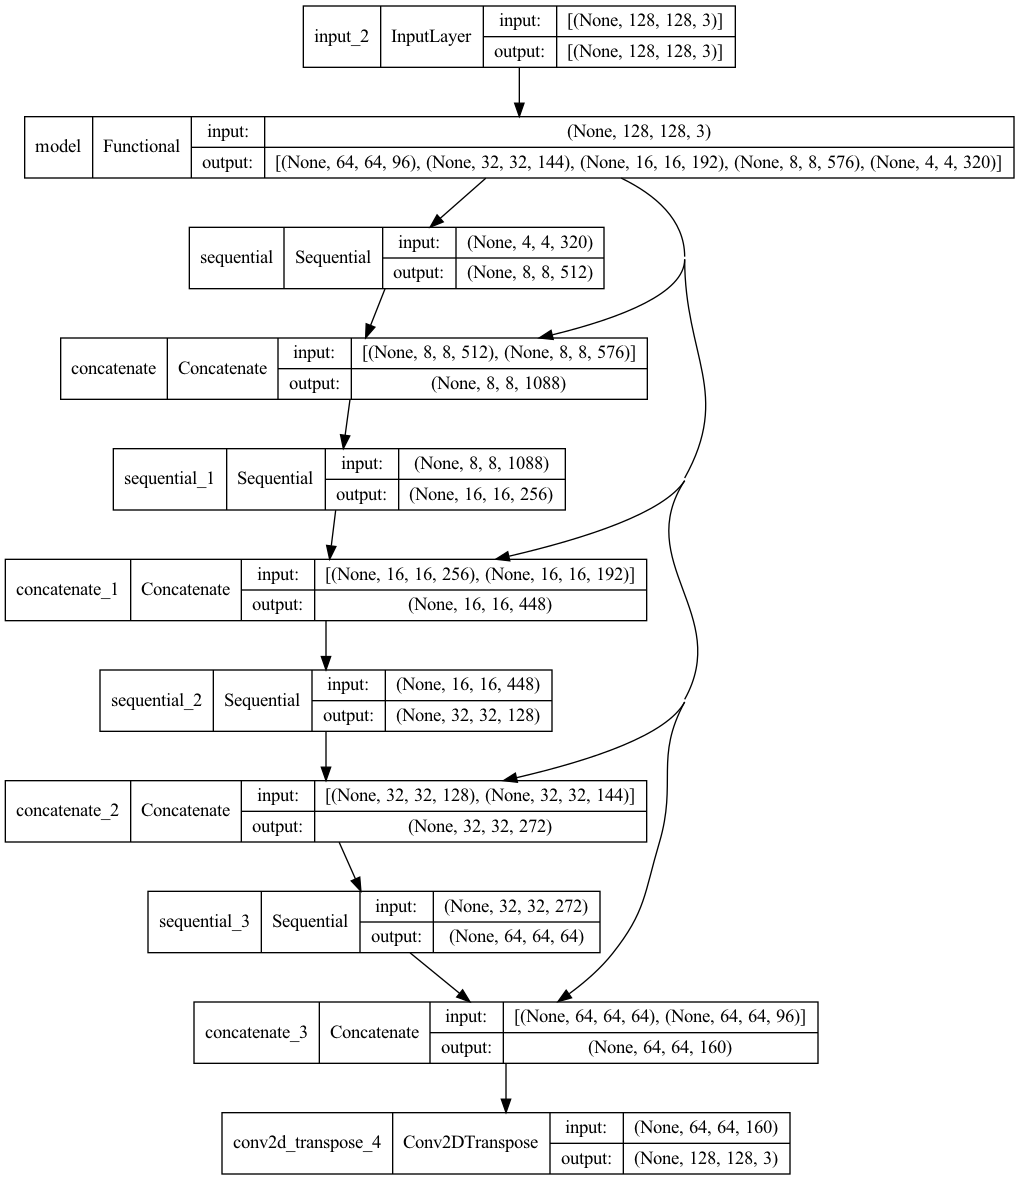

In [28]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [29]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [37]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
                    create_mask(model.predict(sample_image[tf.newaxis, ...]))])

2022-02-10 15:10:09.042286: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


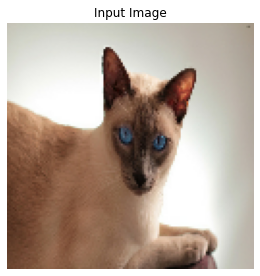

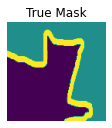

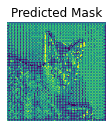

In [69]:
show_predictions()

In [32]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [33]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices(physical_devices[0], 'GPU')
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

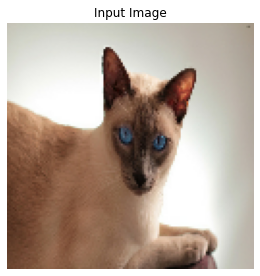

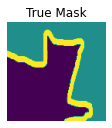

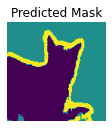


Sample Prediction after epoch 20

57/57 [==============================] - 47s 820ms/step - loss: 0.1859 - accuracy: 0.9177 - val_loss: 0.2731 - val_accuracy: 0.8952


In [70]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

#with tf.device("cpu:0"):
model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()])

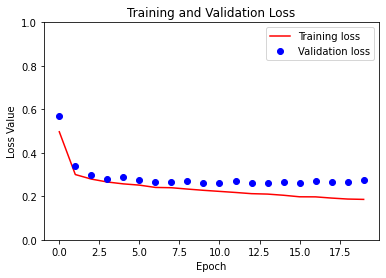

In [71]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

---

### Make Predictions

2022-02-10 15:56:44.083506: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


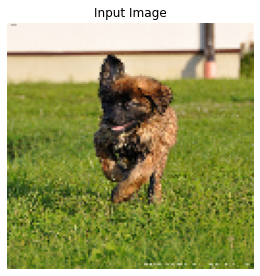

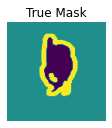

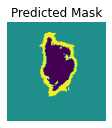

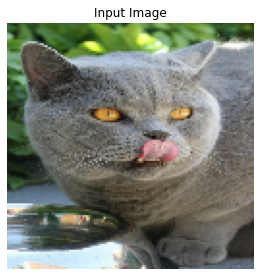

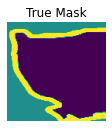

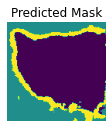

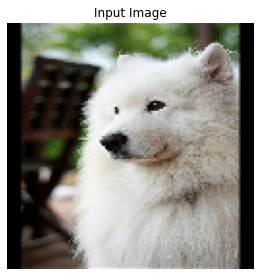

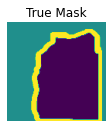

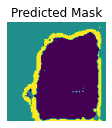

In [72]:
show_predictions(test_batches, 3)

---

### OPTIONAL: Imbalanced classes and class weights

Semantic segmentation datasets can be highly imbalanced meaning that particular class pixels can be present more inside images than that of other classes. Since segmentation problems can be treated as per-pixel classification problems, you can deal with the imbalance problem by weighing the loss function to account for this. It's a simple and elegant way to deal with this problem. Refer to the [Classification on imbalanced data tutorial](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data) to learn more.

To avoid ambiguity, [`Model.fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) does not support the class_weight argument for inputs with 3+ dimensions.

In [73]:
try:
    model_history = model.fit(train_batches, epochs=EPOCHS,
                            steps_per_epoch=STEPS_PER_EPOCH,
                            class_weight = {0:2.0, 1:2.0, 2:1.0})
    assert False
except Exception as e:
    print(f"Expected {type(e).__name__}: {e}")

Expected ValueError: `class_weight` not supported for 3+ dimensional targets.


In [74]:
label = [0,0]
prediction = [[-3., 0], [-3, 0]] 
sample_weight = [1, 10] 

loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True,
                                               reduction=tf.losses.Reduction.NONE)
loss(label, prediction, sample_weight).numpy()

array([ 3.0485873, 30.485874 ], dtype=float32)

In [75]:
def add_sample_weights(image, label):
    # The weights for each class, with the constraint that:
    #     sum(class_weights) == 1.0
    class_weights = tf.constant([2.0, 2.0, 1.0])
    class_weights = class_weights/tf.reduce_sum(class_weights)

    # Create an image of `sample_weights` by using the label at each pixel as an 
    # index into the `class weights` .
    sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))

    return image, label, sample_weights

In [76]:
train_batches.map(add_sample_weights).element_spec

(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))

In [77]:
weighted_model = unet_model(OUTPUT_CLASSES)
weighted_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [78]:
weighted_model.fit(
    train_batches.map(add_sample_weights),
    epochs=1,
    steps_per_epoch=10)

2022-02-10 15:59:11.726335: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 7s 510ms/step - loss: 0.2936 - accuracy: 0.6223
